In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import db_helper
import datetime
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import graph_constructor as GC
import n2v as N2V
import utils

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [3]:
PROJECT_PATH='/home/hmenn/Workspace/CSE496_Node2Vec_2018'

** If you don't have Tweets as JSON file, you can run this statements to read from database **

In [5]:
db = db_helper.DBHelper()
db.connectMysql(user="root",passwd="Hasan5695*",db="SocialMediaDB")
"""
    Read tweets from db and save as json object to use later
    (Using from json is better then MySQL for compatibility).
"""
tweets = db.getTweetsFromMysql("TweetsShort")
tweets.sort(key=lambda t: t.date)
db_helper.saveTweetsAsJson(PROJECT_PATH+"/outputs/TweetsShort.json", tweets)

** If you have JSON input, just run here **

In [7]:
# read tweets and sort them to be sure they are sorted
tweets = db_helper.getTweetsFromJson(PROJECT_PATH+"/dataset/SocialMediaDataset/tweets.json")
tweets.sort(key=lambda t: t.date)

In [10]:
# print an tweet example
tweets[0]

############ Tweet: ############ 
SendByScreenName:osmancoskungazi 
UserID:u540746452 
TweetID:t349518536797978624 
InReplyToStatusID:t-1 
InReplyToUserID:u-1 
Date:2013-06-25 16:24:47 
Text:Hayat bu, bir bakarsın herşey bir anda son bulur.
 Hayat bu, son dediğin an herşey yeniden can bulur..Şemsi Tebrizi 

In [11]:
%%time
G_time2 = GC.create_time_graph2(tweets, is_directed=False)
print("Number of edges: ",G_time2.number_of_edges())
print("Number of nodes: ",G_time2.number_of_nodes())

Number of edges:  106
Number of nodes:  58
CPU times: user 489 ms, sys: 0 ns, total: 489 ms
Wall time: 489 ms


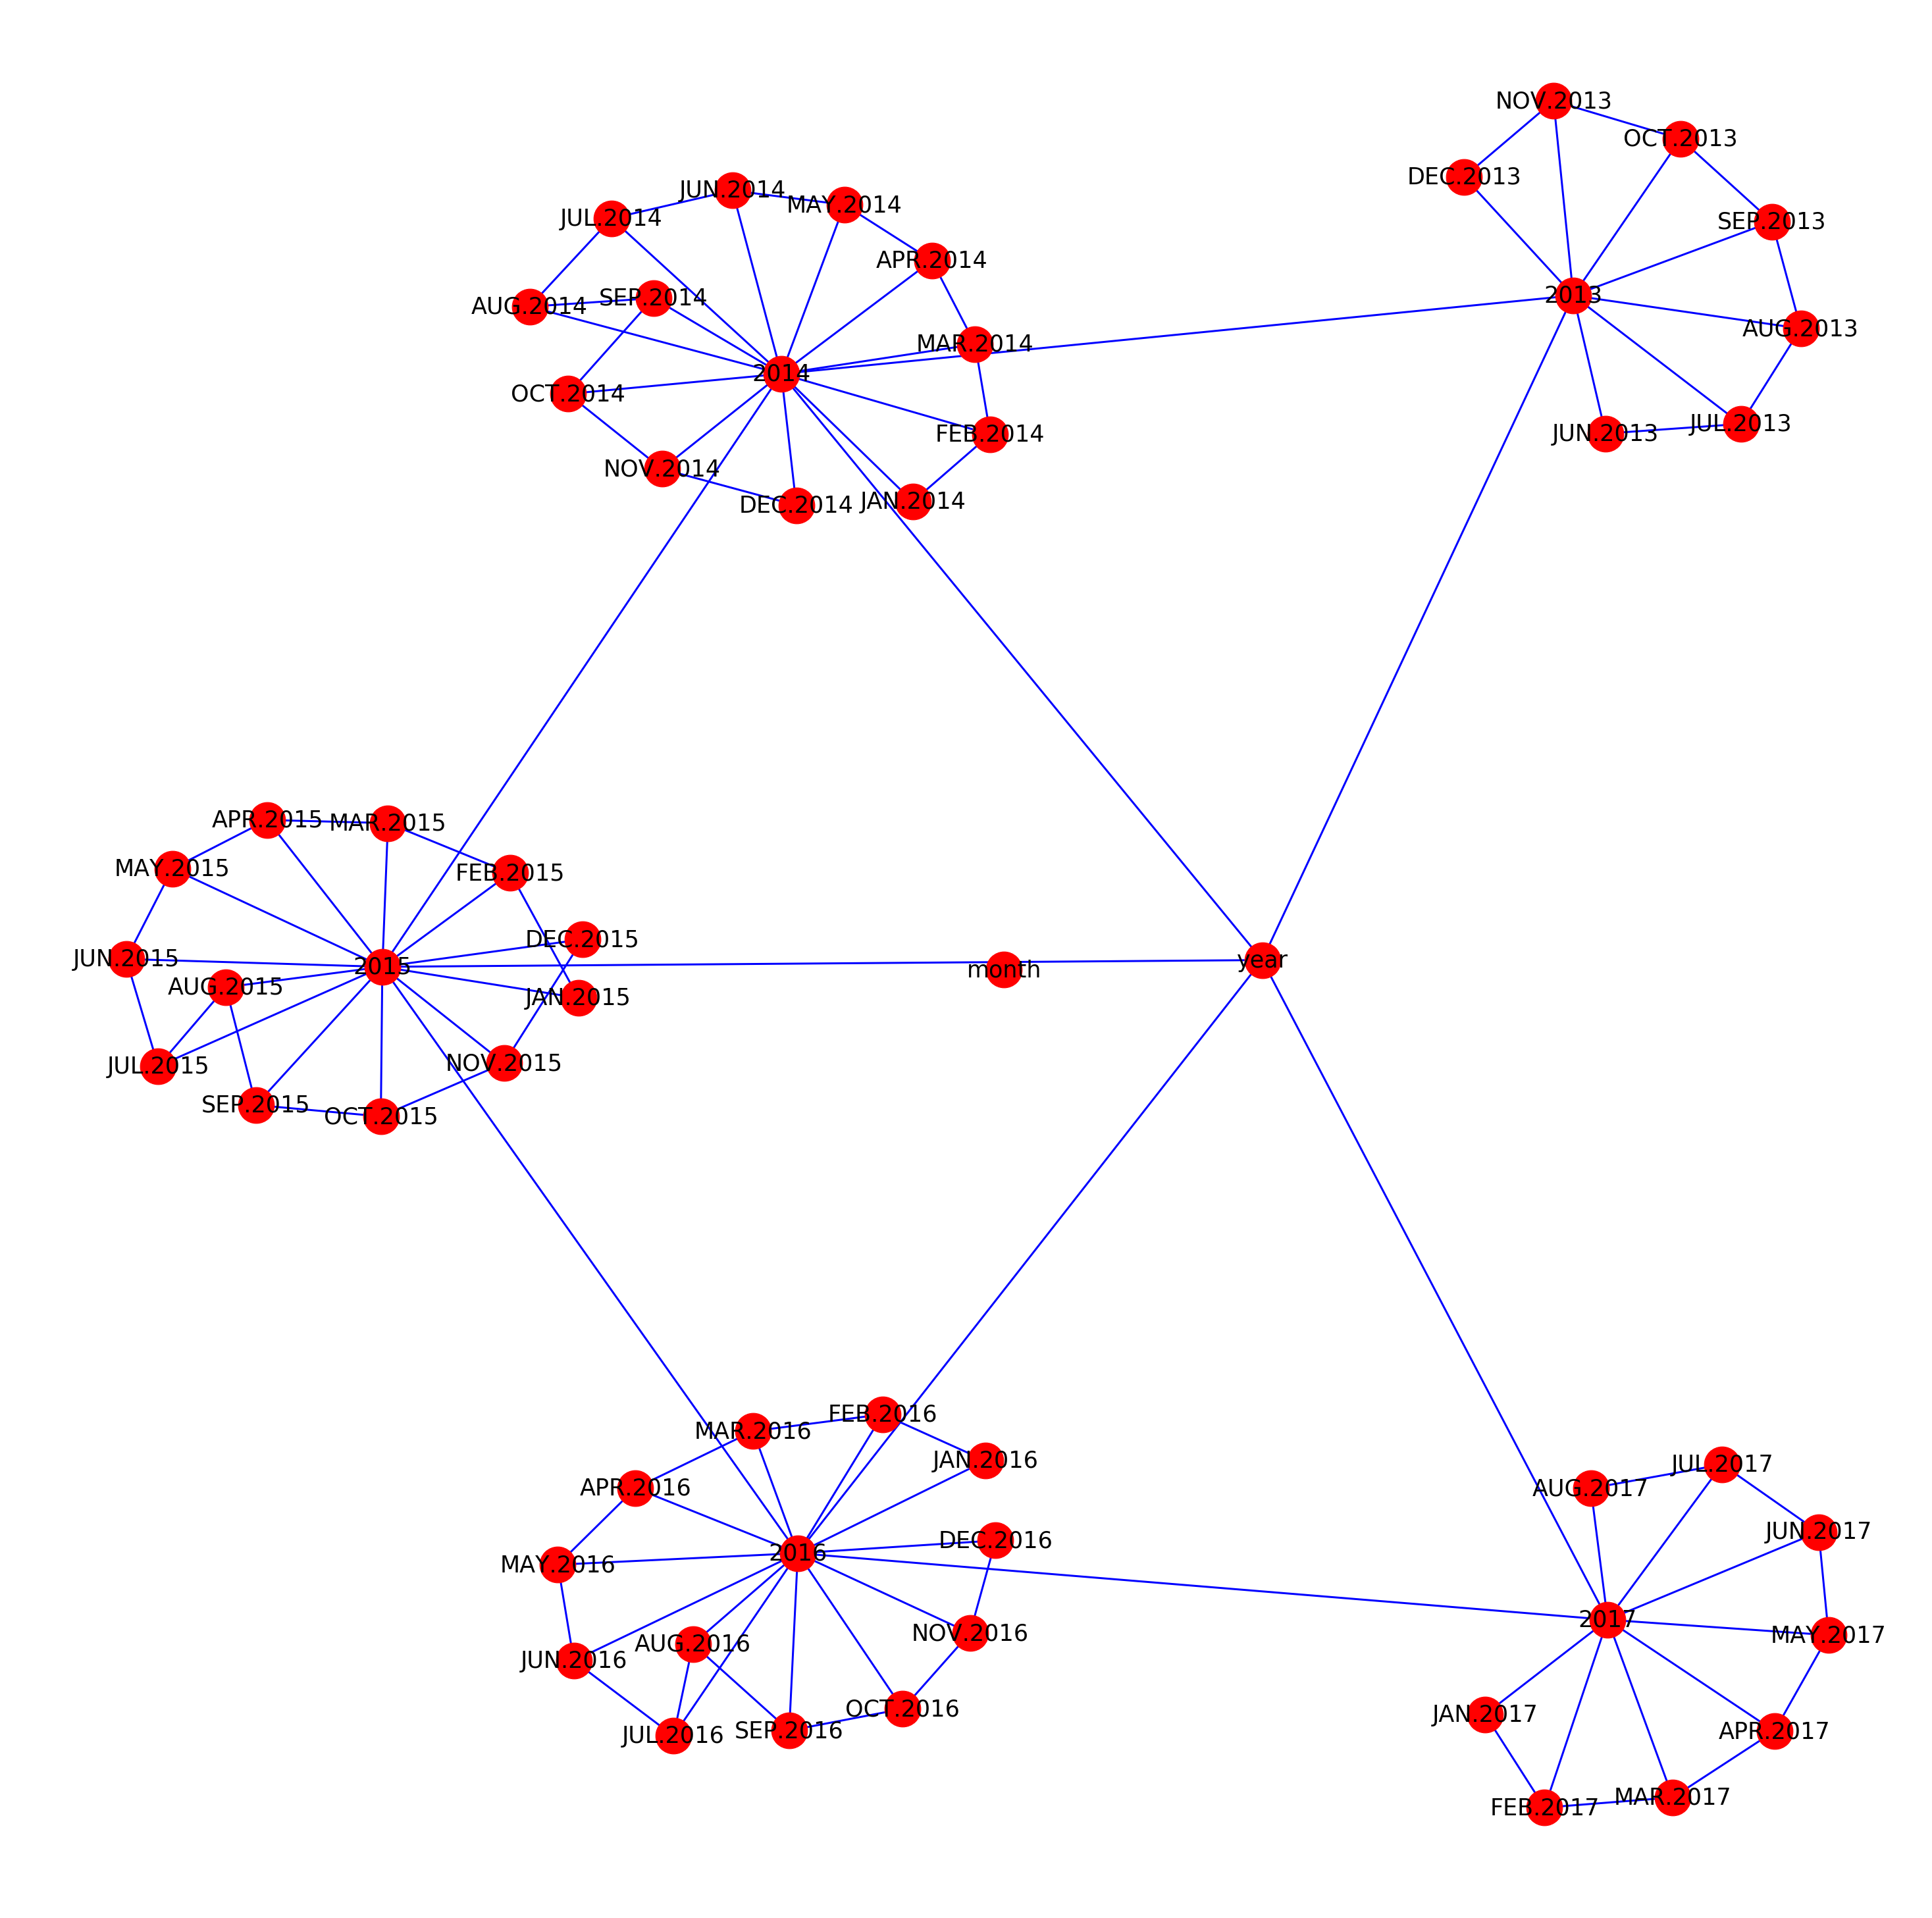

In [12]:
plt.figure(1, figsize=(40,40))
nx.draw_kamada_kawai(G_time2,node_size=3000,font_size=35,with_labels=True, width=3, edge_color="b", arrows=True, arrowsize=30)
plt.savefig(PROJECT_PATH+"/outputs/time_months_nx.pdf")
plt.show()

** Run Node2Vec algorithm to extract vectors from graph **

In [13]:
%%time
G_time2N2V = N2V.Graph(G_time2, is_directed=False, p=1.0, q=1.0)
G_time2N2V.preprocess_transition_probs()
walks = G_time2N2V.simulate_walks(num_walks=1000, walk_length=80)
print('Learning embeddings...')
G_time2_model = N2V.learn_embeddings(walks,"graphTime2")

Walk iteration:
1000 / 1000
Learning embeddings...
CPU times: user 1min 56s, sys: 239 ms, total: 1min 56s
Wall time: 56.9 s


Calculate cosine similarities betweet nodes to see connections

Result: As you can see, the similarity between FEB.2017-JUN.2017 is bigger than FEB.2017-MAY-2016. And this states are shown on other nodes.

In [14]:
column_names = ['2016', 'MAY.2016','JUN.2016', "2017", "JUN.2017", 'FEB.2017']
matrix1 = np.stack((G_time2_model.wv[column_names]))
cosines1 = cosine_similarity(matrix1)
df1 = pd.DataFrame(cosines1, columns=column_names, index=column_names)
df1

,2016,MAY.2016,JUN.2016,2017,JUN.2017,FEB.2017
2016,1.000000,0.740750,0.755314,0.623542,0.524486,0.483705
MAY.2016,0.740750,1.000000,0.815593,0.474035,0.388549,0.365002
JUN.2016,0.755314,0.815593,1.000000,0.460726,0.387262,0.362816
2017,0.623542,0.474035,0.460726,1.000000,0.843384,0.816639
JUN.2017,0.524486,0.388549,0.387262,0.843384,1.000000,0.673380
FEB.2017,0.483705,0.365002,0.362816,0.816639,0.673380,1.000000


In [15]:
# Get most similar vector
G_time2_model.wv.most_similar("2016")

[('MAR.2016', 0.7709778547286987),
 ('JUL.2016', 0.7685554623603821),
 ('OCT.2016', 0.7623921632766724),
 ('SEP.2016', 0.7586111426353455),
 ('JUN.2016', 0.7553136944770813),
 ('AUG.2016', 0.7535209059715271),
 ('APR.2016', 0.7439419031143188),
 ('FEB.2016', 0.7424992322921753),
 ('MAY.2016', 0.7407498359680176),
 ('DEC.2016', 0.7324340343475342)]

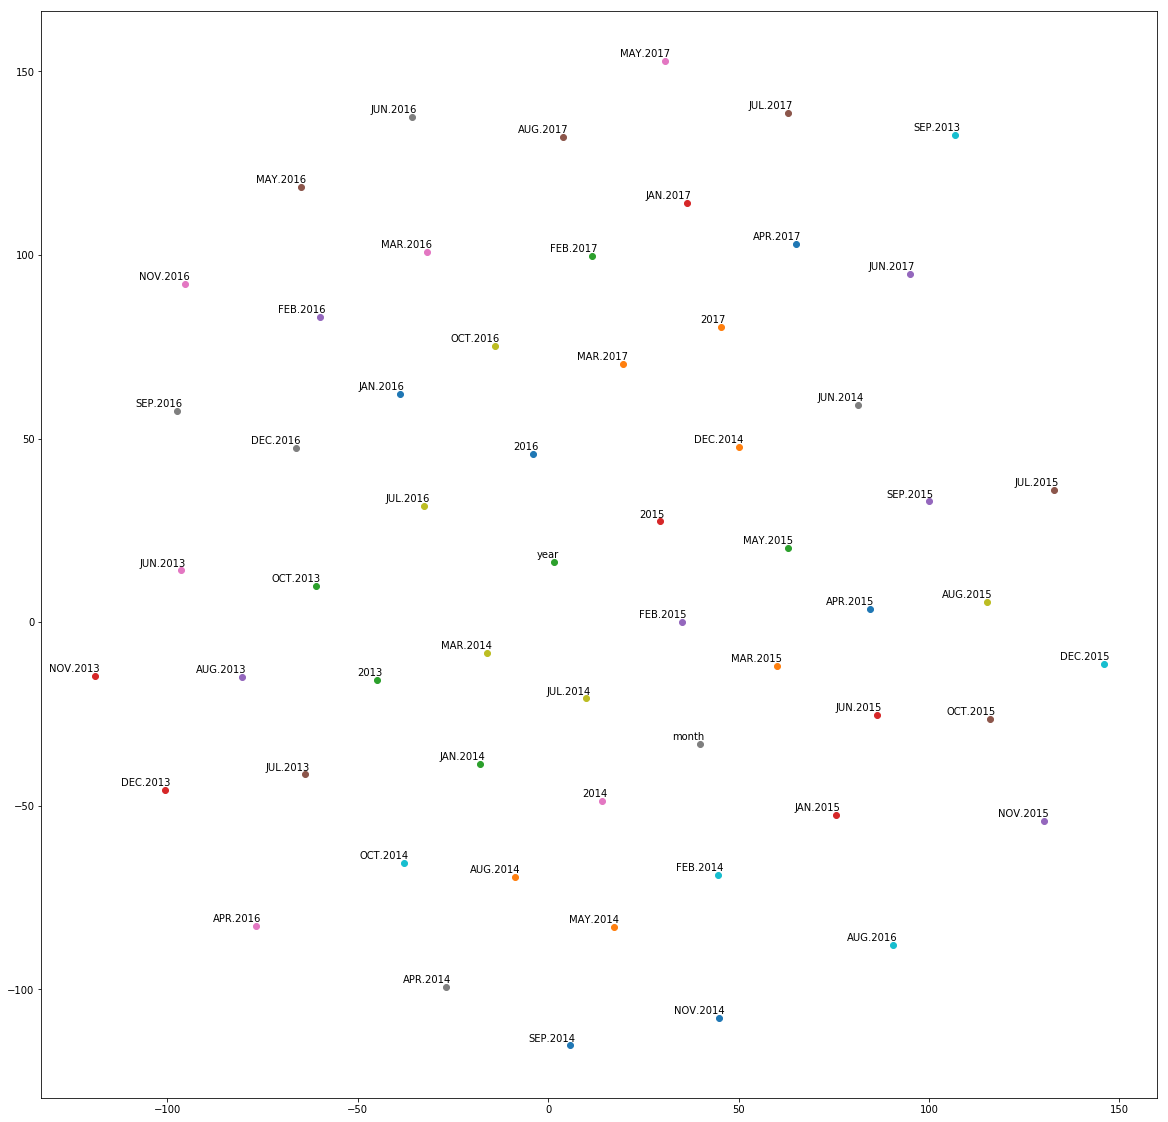

CPU times: user 2.77 s, sys: 1.34 s, total: 4.11 s
Wall time: 3.34 s


In [16]:
%%time
utils.draw_tsne(G_time2_model, fig_size=(20,20))

## Now, draw graph with full date nodes

First draw with weights to see graph, than draw without weights and run node2vec

In [17]:
%%time
G_time3_weighted = GC.create_time_graph3_with_weight(tweets[:100], is_directed=False)
print("Edges #:",G_time3_weighted.number_of_edges()," Nodes #: ",G_time3_weighted.number_of_nodes())

Edges #: 81  Nodes #:  48
CPU times: user 2.4 ms, sys: 0 ns, total: 2.4 ms
Wall time: 2.28 ms


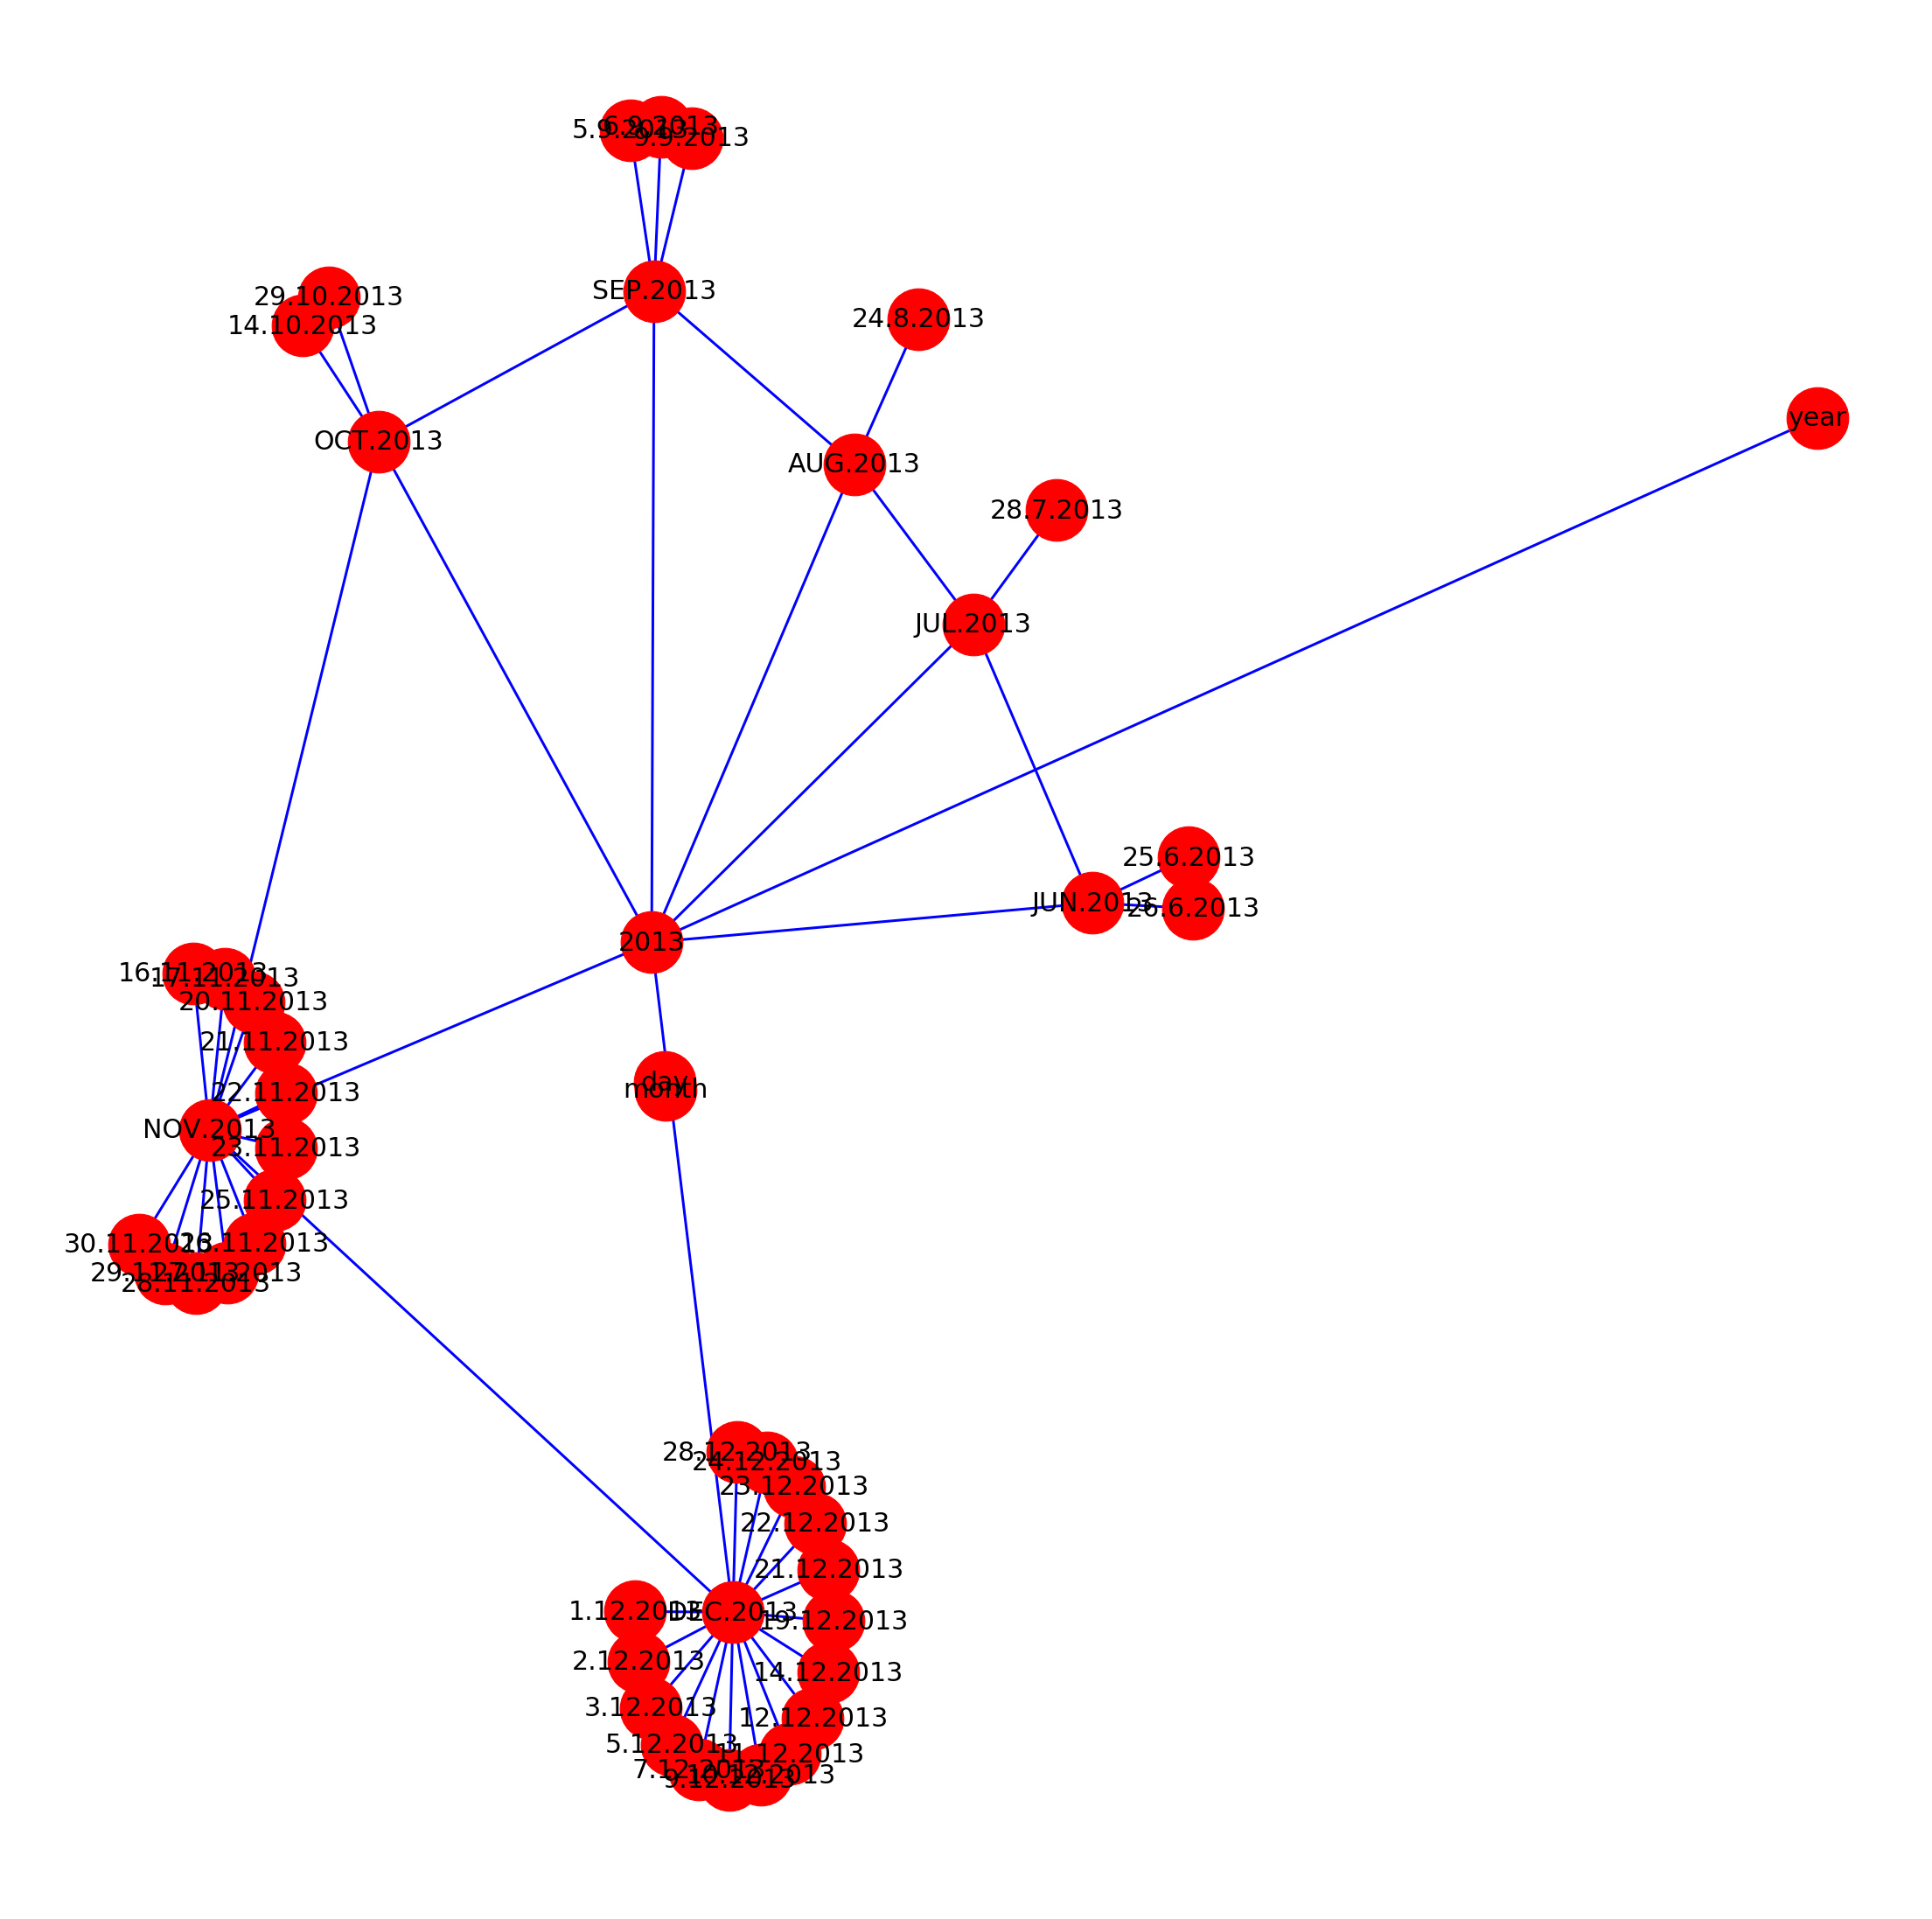

In [19]:
plt.figure(2, figsize=(30,30))
nx.draw_kamada_kawai(G_time3_weighted,node_size=5000,font_size=30,with_labels=True, width=3, edge_color="b", arrows=True, arrowsize=30)
plt.savefig("../outputs/time_day_weighted_nx.pdf")
plt.show()

In [20]:
%%time
G_time3N2V = N2V.Graph(G_time3_weighted, is_directed=False, p=1.0, q=1.0)
G_time3N2V.preprocess_transition_probs()
walks = G_time3N2V.simulate_walks(num_walks=1000, walk_length=80)
print('Now, Learning embeddings...')
G_time3_weighted_model = N2V.learn_embeddings(walks,"time_day_weighted")

Walk iteration:
1000 / 1000
Now, Learning embeddings...
CPU times: user 1min 16s, sys: 292 ms, total: 1min 16s
Wall time: 42.4 s


In [21]:
column_names = ['2013', 'NOV.2013','23.11.2013','30.11.2013','SEP.2013','5.9.2013','9.9.2013']
matrix1 = np.stack((G_time3_weighted_model.wv[column_names]))
cosines1 = cosine_similarity(matrix1)
df1 = pd.DataFrame(cosines1, columns=column_names, index=column_names)
df1

,2013,NOV.2013,23.11.2013,30.11.2013,SEP.2013,5.9.2013,9.9.2013
2013,1.000000,0.597492,0.427014,0.436924,0.773871,0.624613,0.642977
NOV.2013,0.597492,1.000000,0.699990,0.669570,0.524789,0.441978,0.434814
23.11.2013,0.427014,0.699990,1.000000,0.585860,0.389232,0.276692,0.281762
30.11.2013,0.436924,0.669570,0.585860,1.000000,0.407084,0.320237,0.353060
SEP.2013,0.773871,0.524789,0.389232,0.407084,1.000000,0.820852,0.820401
5.9.2013,0.624613,0.441978,0.276692,0.320237,0.820852,1.000000,0.982685
9.9.2013,0.642977,0.434814,0.281762,0.353060,0.820401,0.982685,1.000000


In [22]:
G_time3_weighted_model.wv.most_similar("NOV.2013")

[('26.11.2013', 0.7098733186721802),
 ('20.11.2013', 0.707714319229126),
 ('23.11.2013', 0.6999903321266174),
 ('25.11.2013', 0.6929906010627747),
 ('22.11.2013', 0.6924914121627808),
 ('27.11.2013', 0.6861358284950256),
 ('28.11.2013', 0.6812552809715271),
 ('21.11.2013', 0.6764671206474304),
 ('29.11.2013', 0.675128698348999),
 ('17.11.2013', 0.6709573268890381)]

In [23]:
#load pretrained model
#G_time3_model = Word2Vec.load('/home/hmenn/Workspace/CSE496_Node2Vec_2018/outputs/graphTime3.model')

In [24]:
%%time
G_time3 = GC.create_time_graph3_without_weight(tweets[:100])
print("Edges #:",G_time3.number_of_edges()," Nodes #: ",G_time3.number_of_nodes())

Edges #: 81  Nodes #:  48
CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 2.21 ms


In [25]:
%%time
G_time3v1N2V = N2V.Graph(G_time3, is_directed=False, p=1.0, q=1.0)
G_time3v1N2V.preprocess_transition_probs()
walks = G_time3v1N2V.simulate_walks(num_walks=3000, walk_length=80)
print('Learning Embeddings...')
G_time3_model = N2V.learn_embeddings(walks,"time_day_unweighted")

#G_time3v1_model = Word2Vec.load('/home/hmenn/Workspace/CSE496_Node2Vec_2018/outputs/graphTime3v1.model')

Walk iteration:
1000 / 3000
2000 / 3000
3000 / 3000
Learning Embeddings...
CPU times: user 4min 25s, sys: 1.61 s, total: 4min 27s
Wall time: 2min 35s


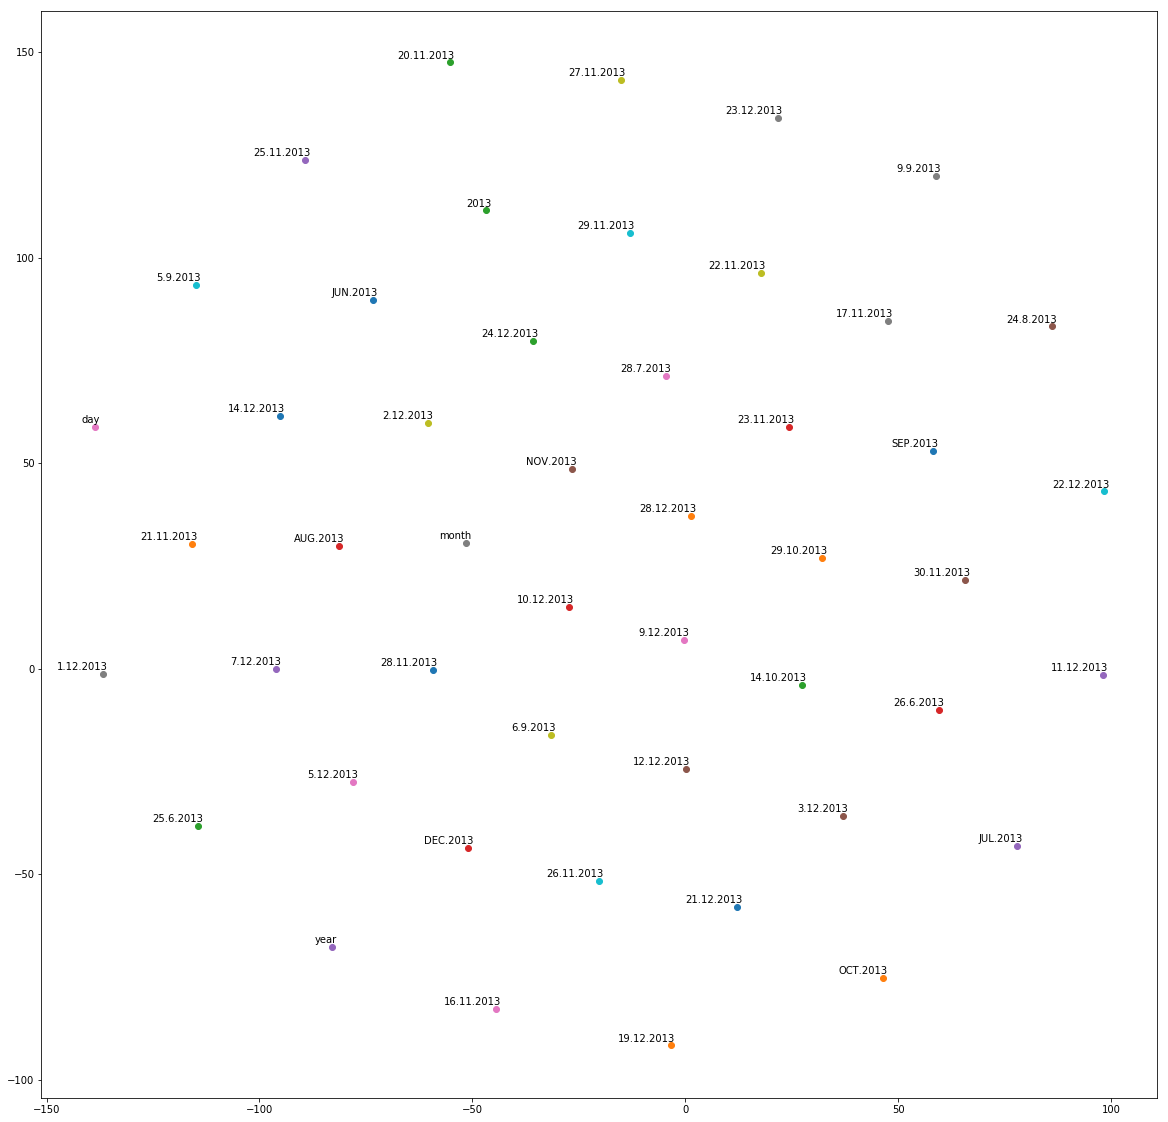

In [26]:
utils.draw_tsne(G_time3_model, fig_size=(20,20))

In [27]:
G_time3_model.wv.most_similar("JUN.2013")

[('25.6.2013', 0.9201733469963074),
 ('26.6.2013', 0.9178793430328369),
 ('JUL.2013', 0.8178760409355164),
 ('28.7.2013', 0.7783988118171692),
 ('2013', 0.7301216721534729),
 ('year', 0.6945112943649292),
 ('AUG.2013', 0.6894252896308899),
 ('24.8.2013', 0.6088594198226929),
 ('SEP.2013', 0.5611609220504761),
 ('9.9.2013', 0.5065434575080872)]

In [28]:
column_names = ['2013', 'NOV.2013','23.11.2013','30.11.2013','SEP.2013','5.9.2013','9.9.2013']
matrix1 = np.stack((G_time3_weighted_model.wv[column_names]))
cosines1 = cosine_similarity(matrix1)
df1 = pd.DataFrame(cosines1, columns=column_names, index=column_names)
df1

,2013,NOV.2013,23.11.2013,30.11.2013,SEP.2013,5.9.2013,9.9.2013
2013,1.000000,0.597492,0.427014,0.436924,0.773871,0.624613,0.642977
NOV.2013,0.597492,1.000000,0.699990,0.669570,0.524789,0.441978,0.434814
23.11.2013,0.427014,0.699990,1.000000,0.585860,0.389232,0.276692,0.281762
30.11.2013,0.436924,0.669570,0.585860,1.000000,0.407084,0.320237,0.353060
SEP.2013,0.773871,0.524789,0.389232,0.407084,1.000000,0.820852,0.820401
5.9.2013,0.624613,0.441978,0.276692,0.320237,0.820852,1.000000,0.982685
9.9.2013,0.642977,0.434814,0.281762,0.353060,0.820401,0.982685,1.000000


In [29]:
# RUN Garbage Collector when memory is full
import gc
gc.collect()

4858